# Quality Assessment Method Comparison

Compare image quality assessment methods on PhotoTriage dataset:
- **Performance metrics**: Top-1/2 Accuracy, MRR, Runtime
- **Correlation analysis**: Which methods agree on series difficulty?
- **Method wins**: Cases where one method succeeds but others fail
- **Failure analysis**: Patterns in failure cases

## Configuration Options

**Option 1 - Single folder**: Specify exact benchmark directory
```python
AUTO_SCAN = False
BENCHMARK_DIR = "outputs/quality_benchmarks/benchmark_2025-11-14_00-06-59"
```

**Option 2 - Auto-scan** (recommended): Automatically find latest benchmark
```python
AUTO_SCAN = True
BENCHMARK_BASE_DIR = "outputs/quality_benchmarks"
```



In [29]:
# === Imports ===
%matplotlib inline
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys

# Add project root to path
sys.path.insert(0, str(Path.cwd().parent))

# Import from specific analysis modules (not from __init__ since it's empty)
from sim_bench.quality_assessment.analysis.load_results import (
    load_quality_results,
    merge_per_series_metrics,
)
from sim_bench.quality_assessment.analysis.correlation import (
    compute_correlation_matrix,
)
from sim_bench.quality_assessment.analysis.visualization import (
    plot_performance_comparison,
    plot_runtime_comparison,
    plot_efficiency_comparison,
    plot_correlation_heatmap,
)
from sim_bench.quality_assessment.analysis.method_wins import (
    find_method_wins,
    visualize_method_wins,
    get_top_methods_by_accuracy,
)
from sim_bench.quality_assessment.analysis.failure_analysis import (
    analyze_failures,
    plot_failure_analysis,
)
from sim_bench.analysis.export import export_notebook_to_pdf, archive_notebook
from sim_bench.analysis.utils import get_project_root

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 100

print("✓ Imports successful")

✓ Imports successful


## Configuration



In [30]:
# === Configuration ===
PROJECT_ROOT = get_project_root()
EXCLUDE_METHODS_REGEX = 'composite'
# Choose scanning mode
AUTO_SCAN = True  # Set to False to use specific folder

if AUTO_SCAN:
    # Option 1: Auto-scan from base directory (uses latest)
    BENCHMARK_BASE_DIR = PROJECT_ROOT / "outputs" / "pairwise_benchmark_3hour"
    BENCHMARK_DIR = None
    USE_LATEST = False
else:
    # Option 2: Specify exact benchmark directory
    BENCHMARK_BASE_DIR = None
    BENCHMARK_DIR = PROJECT_ROOT / "outputs" / "quality_benchmarks" / "benchmark_2025-11-14_00-06-59"
    USE_LATEST = False

# Analysis parameters
TOP_N_METHODS = 10  # Number of top methods to show in wins visualization
TOP_N_IMAGES = 3   # Number of top images to show per method

# Export options
EXPORT_HTML = True  # Export notebook to HTML at the end

print(f"Scanning mode: {'AUTO' if AUTO_SCAN else 'MANUAL'}")
if AUTO_SCAN:
    print(f"Base directory: {BENCHMARK_BASE_DIR.relative_to(PROJECT_ROOT)}")
else:
    print(f"Benchmark directory: {BENCHMARK_DIR.relative_to(PROJECT_ROOT)}")



Scanning mode: AUTO
Base directory: outputs\pairwise_benchmark_3hour


## 1. Load Data



In [ ]:
# Load benchmark results
methods_summary_df, detailed_results_df, series_data_dict, benchmark_dir = load_quality_results(
    benchmark_dir=BENCHMARK_DIR,
    auto_scan=AUTO_SCAN,
    base_dir=BENCHMARK_BASE_DIR,
    use_latest=USE_LATEST
)

print(f"\n{'='*80}")
print("DATA SUMMARY")
print(f"{'='*80}")
print(f"Benchmark directory: {benchmark_dir.name}")
print(f"Methods found: {len(methods_summary_df)}")
print(f"Methods: {', '.join(methods_summary_df['method'].tolist())}")
print(f"\nMethods Summary:")
display(methods_summary_df)

print(f"\nDetailed Results:")
display(detailed_results_df)



No per-series CSV files found



DATA SUMMARY
Benchmark directory: pairwise_20251120_100520
Methods found: 7
Methods: Combined-RuleBased, Sharpness, Colorfulness, Exposure, CLIP-Aesthetic-LAION, CLIP-LearnedPrompts, Contrast

Methods Summary:


,method,avg_top1_accuracy,avg_top2_accuracy,avg_mrr,avg_time_ms,datasets_tested
0,Combined-RuleBased,0.59175,0.0,0.0,414184.616327,1
1,Sharpness,0.56725,0.0,0.0,516029.602766,1
2,Colorfulness,0.56525,0.0,0.0,409536.854029,1
3,Exposure,0.56025,0.0,0.0,404891.614437,1
4,CLIP-Aesthetic-LAION,0.55375,0.0,0.0,454290.904760,1
5,CLIP-LearnedPrompts,0.55375,0.0,0.0,469870.503187,1
6,Contrast,0.49375,0.0,0.0,414460.305929,1



Detailed Results:


,dataset,method,top1_accuracy,top2_accuracy,mrr,avg_time_ms,throughput
0,phototriage,Sharpness,0.56725,0.0,0.0,516029.602766,7.751493
1,phototriage,Exposure,0.56025,0.0,0.0,404891.614437,9.879187
2,phototriage,Contrast,0.49375,0.0,0.0,414460.305929,9.651105
3,phototriage,Colorfulness,0.56525,0.0,0.0,409536.854029,9.767131
4,phototriage,Combined-RuleBased,0.59175,0.0,0.0,414184.616327,9.657529
5,phototriage,CLIP-Aesthetic-LAION,0.55375,0.0,0.0,454290.904760,8.804931
6,phototriage,CLIP-LearnedPrompts,0.55375,0.0,0.0,469870.503187,8.512984


## 2. Performance Metrics Comparison



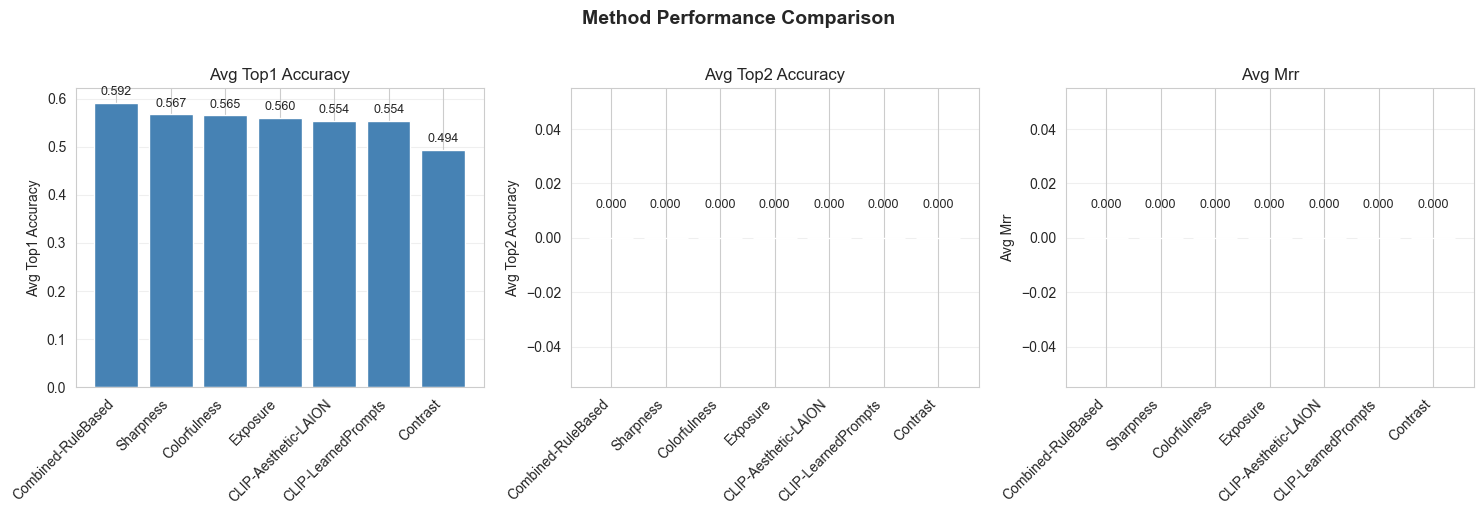

In [ ]:
# Plot performance comparison
fig = plot_performance_comparison(methods_summary_df)
plt.show()



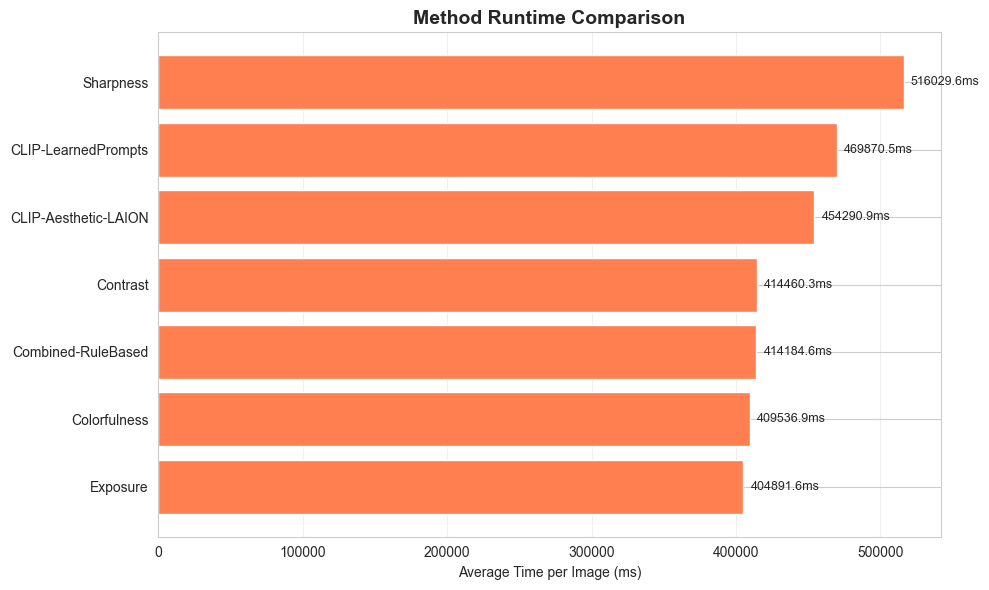

In [ ]:
# Plot runtime comparison
fig = plot_runtime_comparison(detailed_results_df)
plt.show()



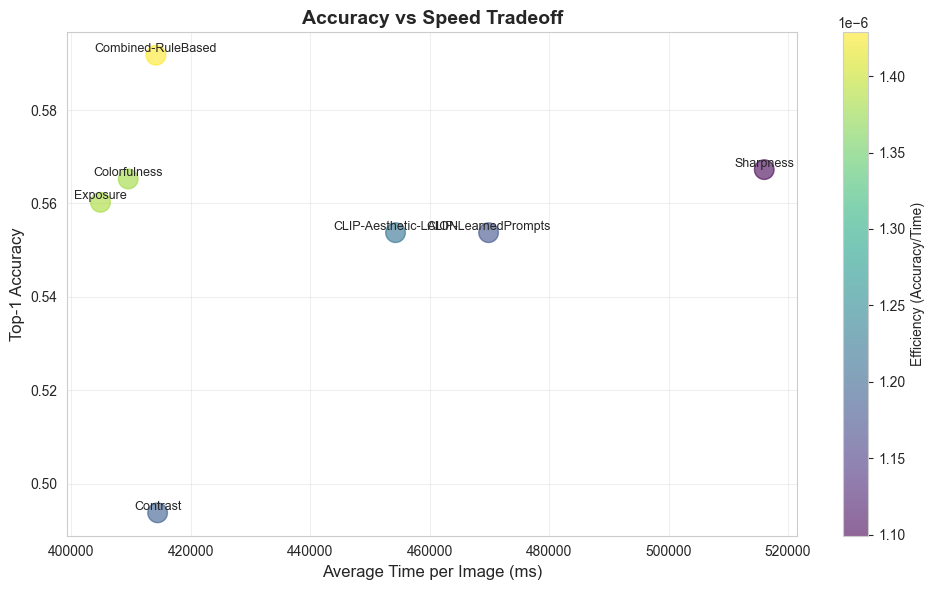

In [ ]:
# Plot efficiency (accuracy vs speed)
fig = plot_efficiency_comparison(methods_summary_df)
plt.show()



## 3. Correlation Matrix

Analyze which methods agree on series difficulty (Top-1 Accuracy correlation).



In [ ]:
# # Merge per-series data for correlation analysis
# methods = methods_summary_df['method'].tolist()
# merged_df = merge_per_series_metrics(series_data_dict, methods=methods, metric='correct')

# print(f"Merged {len(merged_df)} series across {len(methods)} methods")

# # Compute correlation matrix
# corr_matrix = compute_correlation_matrix(merged_df, methods=methods, metric='correct')

# print(f"\nCorrelation Matrix:")
# display(corr_matrix)

# # Plot correlation heatmap
# fig = plot_correlation_heatmap(corr_matrix, methods=methods)
# plt.show()

